Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import imageio
import cv2 as cv

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
NUM_FEATURES = 2048
MAX_SEQ_LENGTH = 40
IMG_SIZE = 456

EPOCHS = 500

In [4]:
df = pd.read_csv('Labels.csv')
df = df.rename(columns={'Inefction_type':'infection'})
df.head()

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315


In [5]:
test = df[(df['Patient']==9)]
test

,Video_Num,infection,Patient,Patient_id
15,24,ca,9,20180920
16,25,cg,9,20180920
17,26,mock,9,20180920


In [6]:
train = pd.concat([df, test]).drop_duplicates(keep=False)
train

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315
5,6,mock,2,20180315
6,13,ca,5,20180409
7,14,cg,5,20180409
8,15,mock,5,20180409
9,18,ca,7,20180914


In [7]:
def concat_arrays(df):

    full_features = []
    full_labels = []

    for i,item in df.iterrows():
    
        features = np.load(f'/asbdata/Arjun/Bloodi/Patch_videos_numpy/videos/{item[0]}_features.npy')
        labels = np.load(f'/asbdata/Arjun/Bloodi/Patch_videos_numpy/labels/{item[0]}_labels.npy')
    
        full_features.extend(features)
        full_labels.extend(labels)
    
    final_features = np.array(full_features)
    final_labels = np.array(full_labels)
    
    return final_features,final_labels

In [8]:
train_data, train_labels = concat_arrays(train)
test_data, test_labels = concat_arrays(test)


print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(1152, 40, 2048)
(1152, 1)
(144, 40, 2048)
(144, 1)


In [9]:
class PositionalEmbedding(layers.Layer):
    
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim
        })
        return config

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [10]:
class TransformerEncoder(layers.Layer):
    
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config

    def call(self, inputs, mask=None):
        
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [11]:
with strategy.scope():
    

    def get_compiled_model():
        
        sequence_length = MAX_SEQ_LENGTH
        embed_dim = NUM_FEATURES
        dense_dim = 4
        num_heads = 4
        classes = 3

        inputs = keras.Input(shape=(None, None))
        x = PositionalEmbedding(sequence_length, embed_dim, name="frame_position_embedding")(inputs)
        x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(classes, activation="softmax")(x)
        model = keras.Model(inputs, outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        )
        
        model.summary()
        
        return model

In [12]:
with strategy.scope():
    
    def run_experiment():
        
        filepath = "Transformer_6.h5"
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, verbose=1)
        stopping = EarlyStopping(monitor='val_loss', patience=30)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=1,mode='auto')

        model = get_compiled_model()
        history = model.fit(
            train_data,
            train_labels,
            validation_split=0.1,
            epochs=EPOCHS,
            callbacks=[checkpoint,stopping,reduce_lr],
        )

        model.load_weights(filepath)
        _, accuracy = model.evaluate(test_data, test_labels)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")

        return model

In [13]:
trained_model = run_experiment()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 2048)       81920     
 ositionalEmbedding)                                             
                                                                 
 transformer_layer (Transfor  (None, None, 2048)       67162116  
 merEncoder)                                                     
                                                                 
 global_max_pooling1d (Globa  (None, 2048)             0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

/home/asarkar/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
29/33 [=========================>....] - ETA: 0s - loss: 1.3129 - accuracy: 0.6735
Epoch 1: val_loss improved from inf to 0.12299, saving model to Transformer_6.h5
33/33 [==============================] - 12s 279ms/step - loss: 1.2379 - accuracy: 0.6824 - val_loss: 0.1230 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 2/500
29/33 [=========================>....] - ETA: 0s - loss: 0.4004 - accuracy: 0.8481
Epoch 2: val_loss improved from 0.12299 to 0.11844, saving model to Transformer_6.h5
33/33 [==============================] - 9s 287ms/step - loss: 0.3920 - accuracy: 0.8504 - val_loss: 0.1184 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 3/500
29/33 [=========================>....] - ETA: 0s - loss: 0.2524 - accuracy: 0.9095
Epoch 3: val_loss improved from 0.11844 to 0.10697, saving model to Transformer_6.h5
33/33 [==============================] - 9s 282ms/step - loss: 0.2499 - accuracy: 0.9083 - val_loss: 0.1070 - val_accuracy: 0.9483 - lr: 1.0000e-04
Epoch 4/500
29/33 [

Epoch 28/500
31/33 [===========================>..] - ETA: 0s - loss: 6.7201e-05 - accuracy: 1.0000
Epoch 28: val_loss did not improve from 0.00508
33/33 [==============================] - 1s 27ms/step - loss: 6.4432e-05 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9914 - lr: 1.0000e-04
Epoch 29/500
32/33 [============================>.] - ETA: 0s - loss: 4.9993e-05 - accuracy: 1.0000
Epoch 29: val_loss did not improve from 0.00508
33/33 [==============================] - 1s 24ms/step - loss: 4.9418e-05 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 30/500
30/33 [==========================>...] - ETA: 0s - loss: 4.6665e-05 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 0.00508

Epoch 30: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
33/33 [==============================] - 1s 25ms/step - loss: 5.5971e-05 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9914 - lr: 1.0000e-04
Epoch 31/500
32/33 [=====

In [12]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [13]:
trained_model = tf.keras.models.load_model('Transformer_6.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})

5/5 [==============================] - 1s 20ms/step


([<matplotlib.axis.YTick at 0x7f364c33dbb0>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

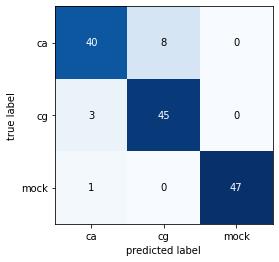

In [14]:
predicted_vals = trained_model.predict(test_data).argmax(axis=1)

labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted_vals)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)